# Term Life Insurance Simulator

Author: Chris Kennedy

Last Update: 9/3/2021

Disclaimer: I'm not an actuary

## Environment Setup

### Imports

In [20]:
import numpy as np
import pandas as pd
import io

In [5]:
! pip install numpy_financial
import numpy_financial as npf

### Raw Data

Raw data sourced from SSA Period Life Tables:
[US SSA.GOV 1999](https://www.ssa.gov/oact/STATS/table4c6.html)

In [55]:
# 1999 US SSN Death Probability Table
# Source: https://www.ssa.gov/oact/STATS/table4c6.html
# Age, MDP, FDP
raw_file_1999 = """
0	0.006081	0.005046
1	0.000425	0.000349
2	0.000260	0.000212
3	0.000194	0.000166
4	0.000154	0.000137
5	0.000142	0.000122
6	0.000135	0.000111
7	0.000127	0.000103
8	0.000117	0.000098
9	0.000104	0.000095
10	0.000097	0.000096
11	0.000106	0.000102
12	0.000145	0.000116
13	0.000220	0.000139
14	0.000324	0.00017
15	0.000437	0.000204
16	0.000552	0.00024
17	0.000676	0.000278
18	0.000806	0.000319
19	0.000939	0.00036
20	0.001079	0.000405
21	0.001215	0.000451
22	0.001327	0.000491
23	0.001406	0.000523
24	0.001461	0.00055
25	0.001508	0.000575
26	0.001559	0.000605
27	0.001612	0.000642
28	0.001671	0.000691
29	0.001734	0.000749
30	0.001798	0.000811
31	0.001860	0.000872
32	0.001926	0.000933
33	0.001994	0.00099
34	0.002067	0.001046
35	0.002147	0.001107
36	0.002233	0.001172
37	0.002318	0.001236
38	0.002399	0.001296
39	0.002483	0.001356
40	0.002581	0.001423
41	0.002697	0.001502
42	0.002828	0.001596
43	0.002976	0.001709
44	0.003145	0.00184
45	0.003339	0.001988
46	0.003566	0.002152
47	0.003831	0.002332
48	0.004142	0.002528
49	0.004498	0.002744
50	0.004888	0.00298
51	0.005319	0.00324
52	0.005808	0.003529
53	0.006360	0.003852
54	0.006970	0.004207
55	0.007627	0.00459
56	0.008320	0.004996
57	0.009047	0.005425
58	0.009803	0.005874
59	0.010591	0.006346
60	0.011447	0.00688
61	0.012352	0.007454
62	0.013248	0.008006
63	0.014117	0.008515
64	0.014995	0.009025
65	0.015987	0.00961
66	0.017107	0.01032
67	0.018280	0.011158
68	0.019500	0.012148
69	0.020829	0.013301
70	0.022364	0.014662
71	0.024169	0.01621
72	0.026249	0.017892
73	0.028642	0.019701
74	0.031380	0.0217
75	0.034593	0.024064
76	0.038235	0.026814
77	0.042159	0.029837
78	0.046336	0.033132
79	0.050917	0.03681
80	0.056205	0.041102
81	0.062327	0.04608
82	0.069190	0.051658
83	0.076844	0.057868
84	0.085407	0.064829
85	0.095010	0.07269
86	0.105770	0.081578
87	0.117771	0.091587
88	0.131063	0.102774
89	0.145666	0.11516
90	0.161582	0.128749
91	0.178797	0.143532
92	0.197287	0.159491
93	0.217013	0.1766
94	0.237930	0.194825
95	0.258655	0.213248
96	0.278786	0.23157
97	0.297897	0.249466
98	0.315556	0.266589
99	0.331333	0.282585
100	0.347900	0.29954
101	0.365295	0.317512
102	0.383560	0.336563
103	0.402738	0.356756
104	0.422875	0.378162
105	0.444018	0.400852
106	0.466219	0.424903
107	0.489530	0.450397
108	0.514007	0.477421
109	0.539707	0.506066
110	0.566692	0.53643
111	0.595027	0.568616
112	0.624778	0.602733
113	0.656017	0.638896
114	0.688818	0.67723
115	0.723259	0.717864
116	0.759422	0.759422
117	0.797393	0.797393
118	0.837263	0.837263
119	0.879126	0.879126"""


In [33]:
death_table_1999 = pd.read_csv(io.StringIO(raw_file_1999), delimiter='\t', names=['Age','MaleDeathProb','FemaleDeathProb'])

In [35]:
death_table_1999.head()

,Age,MaleDeathProb,FemaleDeathProb
0,0,0.006081,0.005046
1,1,0.000425,0.000349
2,2,0.000260,0.000212
3,3,0.000194,0.000166
4,4,0.000154,0.000137


### Parameters and Assumptions

In [6]:
# Simulation Assumptions
n_simulations = 100000  # Number of Simulations
random_seed = 42        # Random Seed
max_term = 30           # Simulation Years Max

In [7]:
# Financial Assumptions
r = 0.0275              # Inflation Rate: 0.025 = 2.5%
t = 20                  # Term Years
payoff = 500000         # Payoff upon death
payment = 68.00         # Monthly Payment

# Constants
MPY = 12                # Months per Year

In [56]:
# Person Assessed
gender = 'male'         # male or female
age = 36

### Functions

In [57]:
def get_probability_table(age, gender):
  if gender == 'male':
    prob_table = death_table_1999['MaleDeathProb'].iloc[age:age+max_term].values
  else:
    prob_table = death_table_1999['FemaleDeathProb'].iloc[age:age+max_term].values
  return prob_table

In [58]:
def get_payoff(flag_vector):
  # Find the first period of death, if none, payoff is zero
  for i in range(t):
    if flag_vector[i] == 1:
      result_idx = i+1
      pay = payoff
      break
  else:
    result_idx = t
    pay = 0

  # Compute present value of the result
  return result_idx, np.round(npf.pv(r/12, result_idx*MPY,payment,-pay), 2)

## Run Simulation

### Initialize

In [48]:
np.random.seed(random_seed)

In [49]:
rand_sample = np.random.rand(n_simulations,max_term)

In [65]:
prob_table = get_probability_table(age, gender)

### Run

In [51]:
scenario_results = []
verbose = 5000

for i in range(n_simulations):
  result_vec = [1 if rand_sample[i][j] < prob_table[j] else 0 for j in range(max_term)]
  term_result, payoff_result = get_payoff(result_vec)
  scenario_results.append([term_result, payoff_result])

  if (i+1) % verbose == 0:
    print("Completing iteration...", i+1)

Completing iteration... 5000
Completing iteration... 10000
Completing iteration... 15000
Completing iteration... 20000
Completing iteration... 25000
Completing iteration... 30000
Completing iteration... 35000
Completing iteration... 40000
Completing iteration... 45000
Completing iteration... 50000
Completing iteration... 55000
Completing iteration... 60000
Completing iteration... 65000
Completing iteration... 70000
Completing iteration... 75000
Completing iteration... 80000
Completing iteration... 85000
Completing iteration... 90000
Completing iteration... 95000
Completing iteration... 100000


In [52]:
my_df = pd.DataFrame(scenario_results, columns=[['Years','Payoff']])
my_df.mean()

Years        19.419130
Payoff    15671.610918
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2d272ce50>,
      dtype=object)

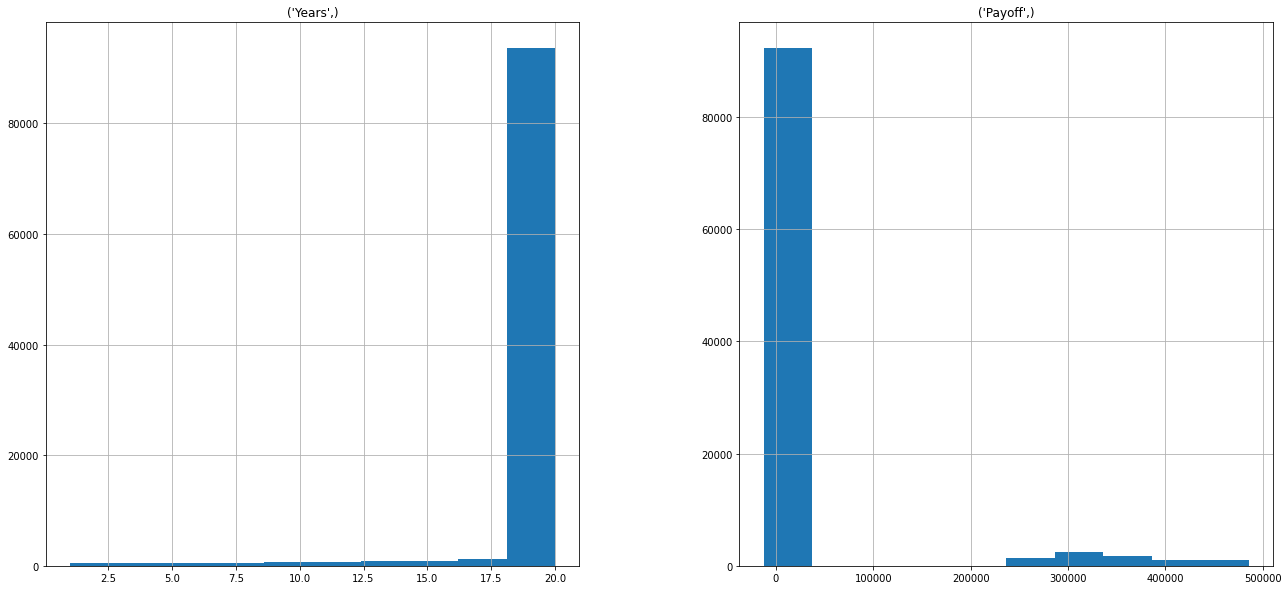

In [64]:
my_df.hist(figsize=[22,10])

### Output to File

In [129]:
my_df.to_csv('output.csv')